In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit','Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=['Disease_Severity'], drop_first=False)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets
target_columns = list(data.filter(regex='Disease_Severity').columns)
# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Bidirectional LSTM model
def create_bidirectional_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(50))(inputs)  # Bidirectional LSTM layer
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the Bidirectional LSTM model
lstm_model = create_bidirectional_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model on training and testing sets
train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3443 - loss: 1.7075
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4420 - loss: 1.4501 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5278 - loss: 1.3147 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5352 - loss: 1.2511 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5294 - loss: 1.2517 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5140 - loss: 1.1914 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5556 - loss: 1.1213 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5924 - loss: 1.0071 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6031 - loss: 0.9736 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6246 - loss: 0.9384 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6551 - loss: 0.8506 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6742 - loss: 0.8493 
Ep

In [7]:
import pandas as pd

# Load the CSV file
file_path = r"B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\src\mahbub\finalDatasetWithUPDRSScore.csv"
data = pd.read_csv(file_path)

In [8]:
print(data.columns)

Index(['Patient ID', 'Visit Date', 'Area', 'Circularity', 'ConvexArea',
       'EquivDiameter', 'Extent', 'FilledArea', 'Kurtosis',
       'Major axis length', 'Mean', 'Minor axis length', 'PA_ratio',
       'Shannon_Entropy', 'Skewness', 'Solidity', 'Standard Deviation',
       'brightness', 'contrast', 'correlation', 'dissimilarity', 'energy',
       'gabor_energy', 'gabor_entropy', 'homogeneity', 'lbp_energy',
       'lbp_entropy', 'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'N

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input
# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")
# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit','Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_columns = "Disease_Severity"
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Visit Class)
data = pd.get_dummies(data, columns=['Disease_Severity'], drop_first=False)
import numpy as np

sequences = []
targets = []

grouped = data.groupby('Patient ID')

import numpy as np


def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets



# Get updated list of target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)
# Create sequences
sequences, targets = create_sequences(data, non_feature_columns,numerical_features,categorical_features, target_columns)
print(sequences.shape)
# Convert sequences and targets to numpy arrays
X = np.array(sequences)
print(X.shape)
y = np.array(targets)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
# Define LSTM model for sequence of 4 visits per patient
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)  # Only one LSTM layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Train LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


# Evaluate LSTM model on training and testing sets
lstm_train_loss, lstm_train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)



print(f"LSTM - Train Loss: {lstm_train_loss}, Train Accuracy: {lstm_train_accuracy}")
print(f"LSTM - Test Loss: {lstm_test_loss}, Test Accuracy: {lstm_test_accuracy}")


(228, 4, 91)
(228, 4, 91)
(182, 4, 91) (46, 4, 91)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0663 - loss: 2.0376   
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3888 - loss: 1.5803 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4946 - loss: 1.4276 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4866 - loss: 1.3820 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4734 - loss: 1.3630 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5022 - loss: 1.2557 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 1.2419 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 1.2062 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5839 - loss: 1.1302 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5959 - loss: 1.1076 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5550 - loss: 1.0786 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━

In [18]:
lstm_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


array([[8.34403187e-03, 1.98630895e-03, 3.13411176e-01, 6.01805687e-01,
        1.04630515e-02, 6.39896840e-02],
       [1.64388461e-04, 8.50410957e-04, 4.60918546e-02, 7.12254703e-01,
        1.93309367e-01, 4.73293178e-02],
       [5.34637074e-04, 6.24826003e-04, 4.66499068e-02, 7.18298197e-01,
        1.06291361e-01, 1.27601162e-01],
       [6.44640326e-02, 1.01261737e-03, 9.17835474e-01, 1.20279668e-02,
        4.28559026e-03, 3.74341995e-04],
       [6.45297952e-03, 1.17002300e-03, 3.22900683e-01, 2.61578709e-01,
        8.05169940e-02, 3.27380598e-01],
       [3.16069648e-02, 1.39169977e-03, 9.62990582e-01, 1.88222260e-03,
        1.89103978e-03, 2.37508997e-04],
       [3.54148971e-04, 5.80920256e-04, 7.82602746e-03, 3.39183718e-01,
        9.09753963e-02, 5.61079800e-01],
       [5.25899923e-05, 4.87734505e-04, 2.68266536e-03, 2.61851903e-02,
        1.68192908e-02, 9.53772426e-01],
       [1.26387784e-03, 3.37434118e-03, 1.17423404e-02, 6.10941529e-01,
        1.17059164e-01, 

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2042 - loss: 1.8193
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4671 - loss: 1.5259 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4280 - loss: 1.4502 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4735 - loss: 1.3418 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5748 - loss: 1.1938 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5331 - loss: 1.1835 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5210 - loss: 1.1630 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6080 - loss: 1.0786 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 1.0668 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5974 - loss: 0.9973 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 0.9545 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6952 - loss: 0.9018 
Ep

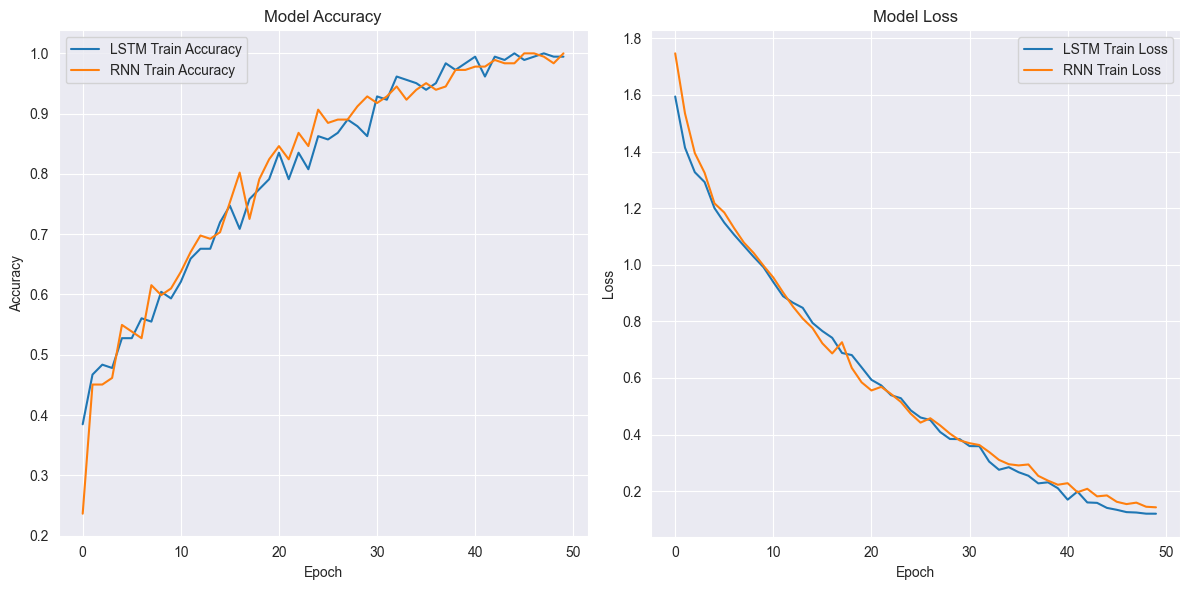

In [19]:
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train SimpleRNN model
rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate SimpleRNN model on training and testing sets
rnn_train_loss, rnn_train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"SimpleRNN - Train Loss: {rnn_train_loss}, Train Accuracy: {rnn_train_accuracy}")
print(f"SimpleRNN - Test Loss: {rnn_test_loss}, Test Accuracy: {rnn_test_accuracy}")

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create LSTM model
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train LSTM model
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")


Fold 1/7
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2482 - loss: 1.7352
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3857 - loss: 1.4632 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4414 - loss: 1.3973 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4447 - loss: 1.3158 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4704 - loss: 1.3099 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4648 - loss: 1.2544 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4755 - loss: 1.2547 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5452 - loss: 1.2034 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5393 - loss: 1.1352 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5137 - loss: 1.1495 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5440 - loss: 1.1118 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5625 - loss: 1

Fold 1/5
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1447 - loss: 1.7884   
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4591 - loss: 1.5145 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4502 - loss: 1.3680 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5059 - loss: 1.3434 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5073 - loss: 1.2437 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5152 - loss: 1.2261 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5052 - loss: 1.1758 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5852 - loss: 1.0929 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5400 - loss: 1.0982 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6080 - loss: 1.0057 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5922 - loss: 0.9907 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5929 - loss

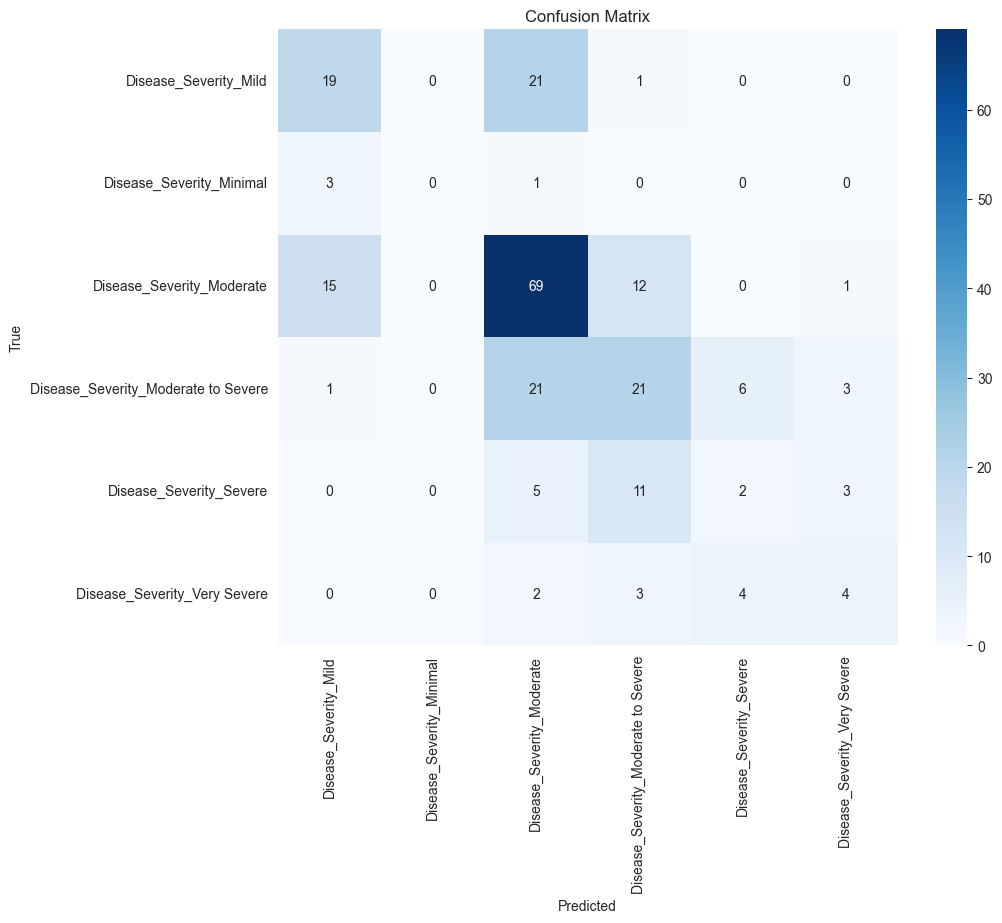

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT']
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY']
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create LSTM model
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Initialize confusion matrix
cm = np.zeros((len(target_columns), len(target_columns)))

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train LSTM model
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)
    
    # Predictions for confusion matrix
    y_pred = lstm_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Update confusion matrix
    cm += confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(target_columns)))

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fold 1/5
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1368 - loss: 2.2596
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4235 - loss: 1.4892 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4650 - loss: 1.4641 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4613 - loss: 1.3128 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5824 - loss: 1.2032 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5137 - loss: 1.2199 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5684 - loss: 1.1148 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4785 - loss: 1.2129 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6267 - loss: 1.0569 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6331 - loss: 1.0311 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6202 - loss: 1.0119 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6949 - loss: 0

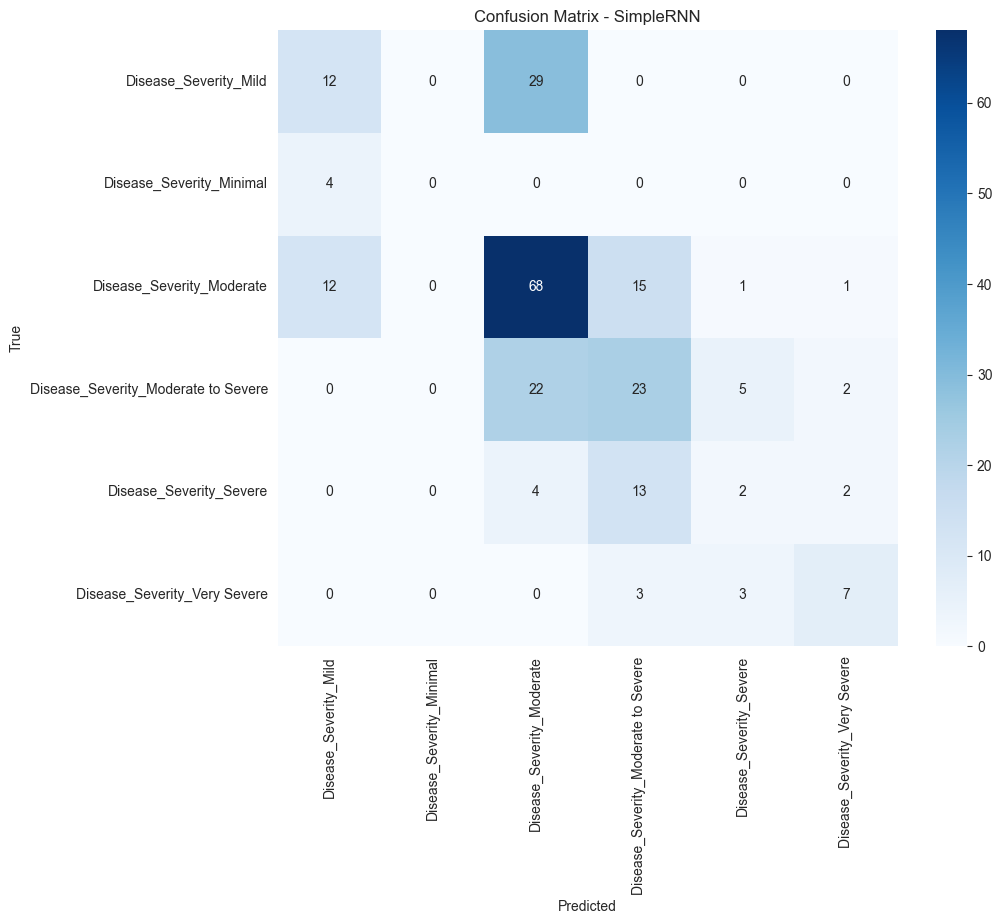

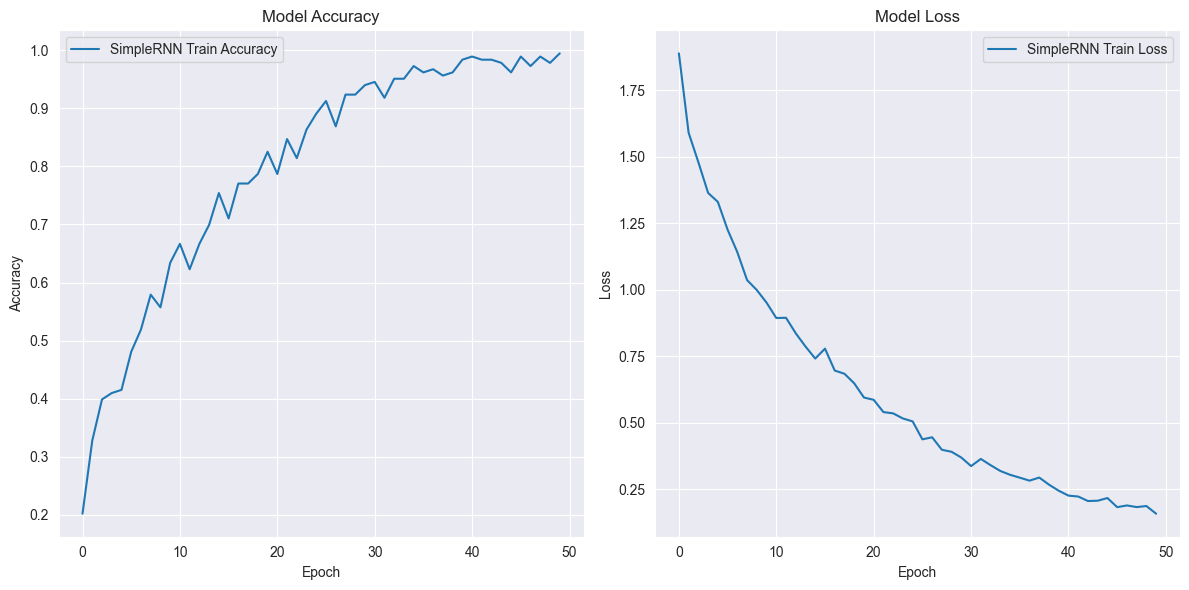

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create SimpleRNN model
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Initialize confusion matrix
cm = np.zeros((len(target_columns), len(target_columns)))

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train SimpleRNN model
    rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)
    
    # Predictions for confusion matrix
    y_pred = rnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Update confusion matrix
    cm += confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(target_columns)))

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SimpleRNN')
plt.show()

# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='SimpleRNN Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='SimpleRNN Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Prepare data for HMM (assuming you have preprocessed your data)
hmm_data = data[numerical_features+categorical_features].values

# Normalize data if necessary (HMMs are sensitive to scale)
# scaler = StandardScaler()
# hmm_data_scaled = scaler.fit_transform(hmm_data)

# Initialize HMM model
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", n_iter=100)

# Fit the model to your data
model.fit(hmm_data)

# Predict the hidden states for the data
hidden_states = model.predict(hmm_data)

# Print the most likely sequence of hidden states
print("Most likely sequence of hidden states:")
print(hidden_states)


Model is not converging.  Current: -64686.68199592506 is not greater than -64686.64361663692. Delta is -0.03837928814027691


Most likely sequence of hidden states:
[0 4 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 0 0 0 1 2 1 5 0 2 1 2 0 2 5 5 3 4 4 4 2
 1 2 5 0 0 1 0 0 0 0 0 1 1 3 2 1 4 2 4 3 1 2 1 2 2 2 4 3 4 4 4 1 1 1 0 0 1
 2 1 0 0 0 2 0 0 1 3 3 4 4 4 2 4 4 4 0 1 1 3 1 3 5 5 3 5 5 5 1 0 1 2 4 3 1
 4 0 4 1 2 3 1 3 2 1 1 1 1 3 3 1 3 3 3 1 3 0 3 1 1 3 2 5 4 1 3 1 1 1 3 1 1
 0 0 0 1 1 1 3 4 1 1 1 1 3 3 3 0 3 3 3 3 3 3 3 3 2 2 5 5 2 3 2 3 1 1 1 0 2
 5 4 4 3 2 4 4 1 1 4 4 0 4 0 1 1 1 1 0 1 3 1 3 1 1 4 4 3 1 2 1 1 2 2 2 1 1
 0 3 1 1 0 1 0 0 1 0 0 0 4 1 0 1 3 4 1 3 1 1 0 1 1 1 3 5 5 5 3 3 3 3 1 1 3
 3 1 2 0 0 1 2 4 2 1 0 3 2 4 2 2 1 0 0 0 2 1 2 2 1 1 1 1 2 0 0 0 2 0 1 0 2
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 4 0 0 1 1 1 0 3 2 2 1 2 2 0 1 4 4 4 5 5 5 0
 0 0 0 5 4 2 5 0 1 0 1 0 2 2 2 0 0 2 2 0 1 1 1 1 1 1 1 0 1 0 1 3 3 3 3 1 0
 1 2 0 5 1 3 2 2 2 4 0 0 0 0 1 1 1 3 0 1 1 2 0 0 1 4 0 1 0 1 1 1 0 1 0 2 2
 5 0 0 1 0 1 2 1 2 2 1 1 1 1 1 1 3 1 1 2 1 3 2 2 5 1 1 5 5 0 0 0 1 2 4 4 2
 0 1 3 3 2 1 1 2 2 1 2 5 1 3 0 1 1 0 1 3 1 1 2 2 2 2 5 2 0 0 

In [24]:
data['Predicted_State'] = hidden_states

# Optionally, you might want to convert the predicted states to integer if they are stored as floats
data['Predicted_State'] = data['Predicted_State'].astype(int)

In [25]:
data

,Patient ID,Visit Date,Area,Circularity,ConvexArea,EquivDiameter,Extent,FilledArea,Kurtosis,Major axis length,...,DATSCAN_CAUDATE_L,DATSCAN_PUTAMEN_R,DATSCAN_PUTAMEN_L,DATSCAN_PUTAMEN_R_ANT,DATSCAN_PUTAMEN_L_ANT,UPDRS_SCORE,Disease_Severity,Visit,Visit_int,Predicted_State
0,3010,2011-07,389.666667,0.347044,537.333333,21.855180,0.552101,393.333333,124.787788,27.661910,...,3.65,0.45,1.24,1.50,2.35,41.0,Moderate,V1,0.0,0
1,3010,2012-06,1242.000000,0.232069,1594.333333,39.709426,0.603968,1248.000000,52.422599,44.351253,...,2.60,0.53,0.78,1.03,1.61,58.0,Moderate to Severe,V2,11.0,4
2,3010,2013-07,887.000000,0.521797,1025.000000,33.604811,0.747054,888.333333,78.186385,36.053962,...,2.50,0.30,0.74,0.85,1.43,67.0,Severe,V3,24.0,2
3,3010,2015-06,737.333333,0.175688,922.000000,25.498446,0.560028,739.666667,63.755847,30.316400,...,1.92,0.44,0.54,0.76,1.02,47.0,Moderate,V4,47.0,2
4,3012,2011-10,862.333333,0.378363,1050.333333,33.124654,0.613324,863.333333,70.920120,39.665361,...,2.05,0.36,0.71,1.10,0.98,48.0,Moderate to Severe,V1,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,137450,2024-03,670.333333,0.119386,1239.000000,28.865941,0.343458,671.666667,50.534147,45.143475,...,2.01,0.45,0.53,0.90,0.94,44.0,Moderate,V4,27.0,2
908,142004,2022-02,975.666667,0.441369,1238.000000,35.225654,0.593963,977.333333,60.710955,42.299448,...,2.45,0.73,1.33,1.31,1.77,68.0,Severe,V1,0.0,2
909,142004,2022-11,1286.333333,0.110355,2265.666667,39.889480,0.396733,1291.000000,66.326636,71.105530,...,2.14,0.48,0.96,0.88,1.50,39.0,Moderate,V2,9.0,2
910,142004,2023-04,1755.333333,0.305589,2503.666667,46.703287,0.621659,1764.333333,51.393542,93.088745,...,2.16,0.59,1.07,1.05,1.79,27.0,Mild,V3,14.0,1


In [29]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load and preprocess your dataset (as previously defined)
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# One-hot encode the target column
encoder = OneHotEncoder()
encoded_targets = encoder.fit_transform(data[[target_column]]).toarray()

# Preprocess numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Prepare sequences for LSTM
def create_sequences(data, numerical_features, categorical_features):
    sequences = []
    targets = []

    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Prepare numerical and categorical data
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Prepare sequences (assuming fixed number of visits per patient)
        if num_visits >= 4:
            sequences.append(patient_data[-4:])  # Last 4 visits
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Target state (last visit's disease severity)
        target = encoded_targets[group.index[-1]]  # One-hot encoded target
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences for LSTM
sequences, targets = create_sequences(data, numerical_features, categorical_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Define and train LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(targets.shape[1], activation='softmax')  # Adjust units for one-hot encoded targets
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Extract LSTM outputs as observations for HMM
lstm_outputs = model.predict(X_train)  # Assuming X_train here, adjust as necessary

# Train HMM on LSTM outputs
hmm_model = GaussianHMM(n_components=targets.shape[1], covariance_type="diag", n_iter=1000)
hmm_model.fit(lstm_outputs)

# Predict with HMM
predicted_states = hmm_model.predict(lstm_outputs)

# Evaluate HMM accuracy or use for further predictions


Epoch 1/50


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3144 - loss: 1.6220
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4680 - loss: 1.4162 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4251 - loss: 1.4278 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4903 - loss: 1.2609 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5725 - loss: 1.1588 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5430 - loss: 1.1704 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5526 - loss: 1.1439 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6018 - loss: 1.0662 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6274 - loss: 0.9830 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5886 - loss: 0.9928 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6166 - loss: 0.9954 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6259 - loss: 0.9191 
Epoch 13/50
6

Model is not converging.  Current: 2390.451130676124 is not greater than 2390.4575780193522. Delta is -0.00644734322804652


In [27]:
print(predicted_states)

[4 1 1 1 1 2 4 1 1 0 1 1 2 2 1 0 0 0 4 2 1 1 0 1 1 0 1 3 1 2 2 0 0 1 1 2 2
 2 0 2 2 1 0 5 5 2 1 0 1 0 1 2 1 1 2 1 2 2 1 1 1 0 2 1 2 1 1 0 1 3 1 2 1 1
 2 1 2 1 4 1 1 2 1 3 0 2 3 2 0 1 1 2 2 2 1 5 2 0 1 0 1 1 1 3 4 2 3 4 2 4 1
 1 0 1 0 1 2 2 3 4 4 0 1 1 3 2 3 4 1 1 0 0 1 1 1 1 0 1 1 2 3 0 1 1 1 1 0 2
 1 2 1 2 2 1 2 2 1 2 1 4 4 1 1 1 1 2 4 2 1 0 1 1 2 1 0 2 1 0 1 5 1 1]


In [30]:
lstm_outputs

array([[1.3954521e-03, 6.2192098e-04, 1.1529742e-02, 1.1453917e-01,
        8.1408781e-01, 5.7825983e-02],
       [3.0213716e-02, 9.0605341e-04, 9.6836311e-01, 4.0574616e-04,
        7.6927921e-05, 3.4433077e-05],
       [1.0978715e-02, 1.9297705e-03, 9.7919011e-01, 7.6130275e-03,
        2.5708819e-04, 3.1239597e-05],
       ...,
       [1.1559488e-01, 8.2419008e-01, 4.5724276e-02, 1.3245232e-02,
        4.1214947e-04, 8.3336118e-04],
       [6.8823539e-02, 1.1497173e-02, 8.0831802e-01, 1.0824946e-01,
        1.8699272e-04, 2.9248616e-03],
       [7.0892242e-03, 1.5119077e-03, 9.7215557e-01, 1.8860707e-02,
        2.3914350e-04, 1.4337317e-04]], dtype=float32)

In [31]:
# Group by 'Disease_Severity' and count rows
grouped_data = data.groupby('Disease_Severity').count()

# Print the grouped data
print(grouped_data)


                    Patient ID  Visit Date  Area  Circularity  ConvexArea  \
Disease_Severity                                                            
Mild                       281         281   281          281         281   
Minimal                     53          53    53           53          53   
Moderate                   346         346   346          346         346   
Moderate to Severe         155         155   155          155         155   
Severe                      58          58    58           58          58   
Very Severe                 19          19    19           19          19   

                    EquivDiameter  Extent  FilledArea  Kurtosis  \
Disease_Severity                                                  
Mild                          281     281         281       281   
Minimal                        53      53          53        53   
Moderate                      346     346         346       346   
Moderate to Severe            155     155       

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Preprocessing pipeline for numerical features
numerical_transformer = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])
# Split data into X (features) and y (target)
X = data[numerical_features + categorical_features]
y = data[target_column]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=20)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Naïve Bayes': GaussianNB(),
    'XGB': XGBClassifier()
}

# Train and evaluate each classifier using PCA reduced features
for name, clf in classifiers.items():
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print metrics
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #             xticklabels=le.classes_, yticklabels=le.classes_)
    # plt.title(f'Confusion matrix for {name}')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()



Random Forest:
Accuracy: 0.7705
Precision: 0.8081
Recall: 0.7705
F1-score: 0.7590

Logistic Regression:
Accuracy: 0.8907
Precision: 0.9035
Recall: 0.8907
F1-score: 0.8893

AdaBoost:
Accuracy: 0.6120
Precision: 0.5544
Recall: 0.6120
F1-score: 0.5620

Decision Tree:
Accuracy: 0.8087
Precision: 0.8210
Recall: 0.8087
F1-score: 0.8103


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting:
Accuracy: 0.8525
Precision: 0.8546
Recall: 0.8525
F1-score: 0.8502

KNN:
Accuracy: 0.6393
Precision: 0.6514
Recall: 0.6393
F1-score: 0.6271

SVM:
Accuracy: 0.8470
Precision: 0.8708
Recall: 0.8470
F1-score: 0.8446

Naïve Bayes:
Accuracy: 0.7814
Precision: 0.7842
Recall: 0.7814
F1-score: 0.7795

XGB:
Accuracy: 0.8525
Precision: 0.8680
Recall: 0.8525
F1-score: 0.8499


In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Split data into X (features) and y (target)
X = data[numerical_features + categorical_features]
y = data[target_column]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply LDA for dimensionality reduction
lda = LDA(n_components=5)  # Adjust the number of components as needed
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'AdaBoost': AdaBoostClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Naïve Bayes': GaussianNB(),
    'XGB': XGBClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_lda, y_train)
    y_train_pred = clf.predict(X_train_lda)
    y_test_pred = clf.predict(X_test_lda)
    
    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    
    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Print metrics
    print(f"\n{name}:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing F1-score: {test_f1:.4f}")

    
    # Plot confusion matrix
    # cm = confusion_matrix(y_test, y_pred)
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #             xticklabels=le.classes_, yticklabels=le.classes_)
    # plt.title(f'Confusion matrix for {name}')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()



Random Forest:
Training Accuracy: 1.0000
Testing Accuracy: 0.9126
Testing Precision: 0.9203
Testing Recall: 0.9126
Testing F1-score: 0.9117

Logistic Regression:
Training Accuracy: 0.9643
Testing Accuracy: 0.8743
Testing Precision: 0.8843
Testing Recall: 0.8743
Testing F1-score: 0.8710

AdaBoost:
Training Accuracy: 0.6914
Testing Accuracy: 0.6885
Testing Precision: 0.5006
Testing Recall: 0.6885
Testing F1-score: 0.5797

Decision Tree:
Training Accuracy: 1.0000
Testing Accuracy: 0.8743
Testing Precision: 0.8903
Testing Recall: 0.8743
Testing F1-score: 0.8718


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Gradient Boosting:
Training Accuracy: 1.0000
Testing Accuracy: 0.8907
Testing Precision: 0.9037
Testing Recall: 0.8907
Testing F1-score: 0.8875

KNN:
Training Accuracy: 0.9657
Testing Accuracy: 0.8689
Testing Precision: 0.8826
Testing Recall: 0.8689
Testing F1-score: 0.8650

SVM:
Training Accuracy: 0.9657
Testing Accuracy: 0.8852
Testing Precision: 0.8994
Testing Recall: 0.8852
Testing F1-score: 0.8806

Naïve Bayes:
Training Accuracy: 0.9561
Testing Accuracy: 0.9180
Testing Precision: 0.9279
Testing Recall: 0.9180
Testing F1-score: 0.9188

XGB:
Training Accuracy: 1.0000
Testing Accuracy: 0.9180
Testing Precision: 0.9215
Testing Recall: 0.9180
Testing F1-score: 0.9175


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import FactorAnalysis, FastICA, NMF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Preprocessing pipeline for numerical features
numerical_transformer = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])
# Split data into X (features) and y (target)
X = data[numerical_features + categorical_features]
y = data[target_column]

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define dimensionality reduction techniques
dimensionality_reduction_techniques = {
    'Factor Analysis': FactorAnalysis(n_components=5, random_state=42),
    'Independent Component Analysis': FastICA(n_components=5, random_state=42),
    'Non-negative Matrix Factorization': NMF(n_components=5, init='random', random_state=42)
}

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42),  # Specify SAMME algorithm to avoid warning
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Naïve Bayes': GaussianNB(),
    'XGB': XGBClassifier()
}

# Iterate over each dimensionality reduction technique
for dr_name, dr_model in dimensionality_reduction_techniques.items():
    # Fit and transform X_train with the dimensionality reduction technique
    X_train_dr = dr_model.fit_transform(X_train, y_train)
    
    # Transform X_test with the trained dimensionality reduction model
    X_test_dr = dr_model.transform(X_test)
    
    print(f"\nApplying {dr_name}:")
    
    # Train and evaluate each classifier using the reduced features
    for clf_name, clf_model in classifiers.items():
        clf_model.fit(X_train_dr, y_train)
        y_pred = clf_model.predict(X_test_dr)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Handle zero division warning
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Print metrics
        print(f"\n{clf_name} after {dr_name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
        # 
        # # Plot confusion matrix
        # cm = confusion_matrix(y_test, y_pred)
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
        #             xticklabels=le.classes_, yticklabels=le.classes_)
        # plt.title(f'Confusion matrix for {clf_name} after {dr_name}')
        # plt.xlabel('Predicted')
        # plt.ylabel('True')
        # plt.show()



Applying Factor Analysis:

Random Forest after Factor Analysis:
Accuracy: 0.6503
Precision: 0.6494
Recall: 0.6503
F1-score: 0.6452

Logistic Regression after Factor Analysis:
Accuracy: 0.6667
Precision: 0.6545
Recall: 0.6667
F1-score: 0.6443

AdaBoost after Factor Analysis:
Accuracy: 0.5027
Precision: 0.5678
Recall: 0.5027
F1-score: 0.4610

Decision Tree after Factor Analysis:
Accuracy: 0.6175
Precision: 0.6276
Recall: 0.6175
F1-score: 0.6179

Gradient Boosting after Factor Analysis:
Accuracy: 0.6230
Precision: 0.6285
Recall: 0.6230
F1-score: 0.6191

KNN after Factor Analysis:
Accuracy: 0.6448
Precision: 0.6587
Recall: 0.6448
F1-score: 0.6332

SVM after Factor Analysis:
Accuracy: 0.6448
Precision: 0.6061
Recall: 0.6448
F1-score: 0.6180

Naïve Bayes after Factor Analysis:
Accuracy: 0.5956
Precision: 0.5515
Recall: 0.5956
F1-score: 0.5705

XGB after Factor Analysis:
Accuracy: 0.6284
Precision: 0.6332
Recall: 0.6284
F1-score: 0.6289

Applying Independent Component Analysis:

Random Fores

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



Random Forest after Non-negative Matrix Factorization:
Accuracy: 0.6230
Precision: 0.6165
Recall: 0.6230
F1-score: 0.6141

Logistic Regression after Non-negative Matrix Factorization:
Accuracy: 0.7104
Precision: 0.6273
Recall: 0.7104
F1-score: 0.6556

AdaBoost after Non-negative Matrix Factorization:
Accuracy: 0.5082
Precision: 0.4561
Recall: 0.5082
F1-score: 0.4744

Decision Tree after Non-negative Matrix Factorization:
Accuracy: 0.5628
Precision: 0.5559
Recall: 0.5628
F1-score: 0.5563

Gradient Boosting after Non-negative Matrix Factorization:
Accuracy: 0.6393
Precision: 0.6421
Recall: 0.6393
F1-score: 0.6292

KNN after Non-negative Matrix Factorization:
Accuracy: 0.7213
Precision: 0.7056
Recall: 0.7213
F1-score: 0.7055

SVM after Non-negative Matrix Factorization:
Accuracy: 0.7486
Precision: 0.7693
Recall: 0.7486
F1-score: 0.7355

Naïve Bayes after Non-negative Matrix Factorization:
Accuracy: 0.6011
Precision: 0.6128
Recall: 0.6011
F1-score: 0.5819

XGB after Non-negative Matrix Fa

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]

target_column = 'Disease_Severity'

# Apply MinMaxScaler to numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Function to create sequences and targets
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)

        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Get the target sequence (last visit classes one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets
target_columns = [
    'Disease_Severity_Mild', 'Disease_Severity_Minimal',
    'Disease_Severity_Moderate', 'Disease_Severity_Moderate to Severe',
    'Disease_Severity_Severe', 'Disease_Severity_Very Severe'
]

sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.40)  # Retain 95% variance
sequences_pca = pca.fit_transform(np.reshape(sequences, (-1, sequences.shape[-1])))
sequences_pca = np.reshape(sequences_pca, (sequences.shape[0], -1, sequences_pca.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences_pca, targets, test_size=0.2, random_state=42)

# Define LSTM model
def create_lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(output_shape, activation='sigmoid'))  # Adjusted activation function for multi-label classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjusted loss function for multi-label classification
    return model

# Train LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate LSTM model on training and testing sets
train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM - Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
print(f"LSTM - Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Epoch 1/50


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1643 - loss: 0.6952
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2292 - loss: 0.6759 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2965 - loss: 0.6498 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2954 - loss: 0.6308 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3376 - loss: 0.6073 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3950 - loss: 0.5866 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4034 - loss: 0.5584 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4624 - loss: 0.5266 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4838 - loss: 0.4977 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5182 - loss: 0.4656 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4942 - loss: 0.4285 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4216 - loss: 0.4103 
Epoch 13/50
6

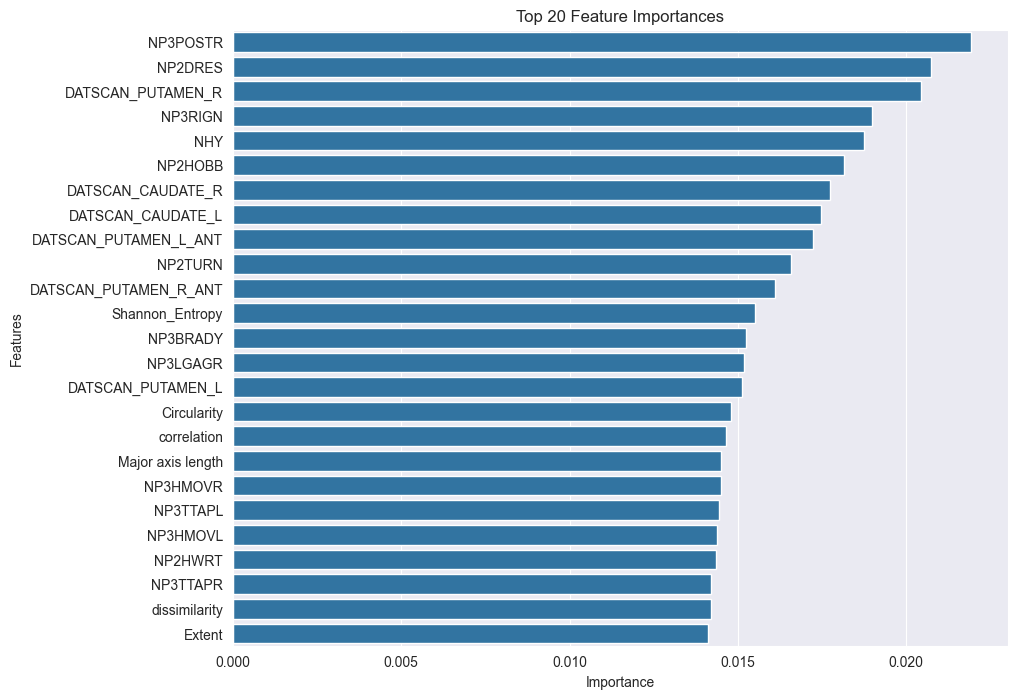


--- Training and evaluating classifiers on top 10% features ---
Selected Features for Random Forest: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT']

Random Forest (9 features):
Accuracy: 0.5301
Precision: 0.5197
Recall: 0.5301
F1-score: 0.5080
Selected Features for Logistic Regression: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT']


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Logistic Regression (9 features):
Accuracy: 0.5847
Precision: 0.5657
Recall: 0.5847
F1-score: 0.5466
Selected Features for AdaBoost: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT']

AdaBoost (9 features):
Accuracy: 0.5246
Precision: 0.3905
Recall: 0.5246
F1-score: 0.4435
Selected Features for Decision Tree: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT']

Decision Tree (9 features):
Accuracy: 0.4481
Precision: 0.4619
Recall: 0.4481
F1-score: 0.4462
Selected Features for Gradient Boosting: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT']

Gradient Boosting (9 features):
Accuracy: 0.5137
Precision: 0.5149
Recall: 0.5137
F1-score: 0.5098
Selected Features for KNN: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RI

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



XGB (9 features):
Accuracy: 0.5519
Precision: 0.5553
Recall: 0.5519
F1-score: 0.5395

--- Training and evaluating classifiers on top 20% features ---
Selected Features for Random Forest: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length']

Random Forest (18 features):
Accuracy: 0.6120
Precision: 0.6117
Recall: 0.6120
F1-score: 0.5968
Selected Features for Logistic Regression: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length']

Logistic Regression (18 features):
Accuracy: 0.5956
Precision: 0.5799
Recall: 0.5956
F1

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting (18 features):
Accuracy: 0.5847
Precision: 0.5736
Recall: 0.5847
F1-score: 0.5741
Selected Features for KNN: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length']

KNN (18 features):
Accuracy: 0.5519
Precision: 0.5573
Recall: 0.5519
F1-score: 0.5370
Selected Features for SVM: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length']

SVM (18 features):
Accuracy: 0.6011
Precision: 0.5698
Recall: 0.6011
F1-score: 0.5684
Selected Features for Naïve Bayes: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIG

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting (27 features):
Accuracy: 0.6667
Precision: 0.6685
Recall: 0.6667
F1-score: 0.6627
Selected Features for KNN: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length', 'NP3HMOVR', 'NP3TTAPL', 'NP3HMOVL', 'NP2HWRT', 'NP3TTAPR', 'dissimilarity', 'Extent', 'NP1PAIN', 'NP2EAT']

KNN (27 features):
Accuracy: 0.5847
Precision: 0.6195
Recall: 0.5847
F1-score: 0.5704
Selected Features for SVM: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length', 'NP3HMOVR', 'NP3TTAPL', 'NP3HMOVL', 'NP2HWRT', 'NP3TTAPR', 'dissimi

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting (36 features):
Accuracy: 0.6940
Precision: 0.7042
Recall: 0.6940
F1-score: 0.6934
Selected Features for KNN: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length', 'NP3HMOVR', 'NP3TTAPL', 'NP3HMOVL', 'NP2HWRT', 'NP3TTAPR', 'dissimilarity', 'Extent', 'NP1PAIN', 'NP2EAT', 'ConvexArea', 'Solidity', 'lbp_entropy', 'PA_ratio', 'Minor axis length', 'NP3FTAPR', 'EquivDiameter', 'contrast', 'homogeneity']

KNN (36 features):
Accuracy: 0.5902
Precision: 0.6001
Recall: 0.5902
F1-score: 0.5672
Selected Features for SVM: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting (45 features):
Accuracy: 0.6557
Precision: 0.6552
Recall: 0.6557
F1-score: 0.6504
Selected Features for KNN: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length', 'NP3HMOVR', 'NP3TTAPL', 'NP3HMOVL', 'NP2HWRT', 'NP3TTAPR', 'dissimilarity', 'Extent', 'NP1PAIN', 'NP2EAT', 'ConvexArea', 'Solidity', 'lbp_entropy', 'PA_ratio', 'Minor axis length', 'NP3FTAPR', 'EquivDiameter', 'contrast', 'homogeneity', 'energy', 'NP3PRSPL', 'gabor_entropy', 'Area', 'lbp_energy', 'gabor_energy', 'FilledArea', 'NP3LGAGL', 'NP2RISE']

KNN (45 features):
Accuracy: 0.6120
Precision: 0.6270
Recall: 0.6120
F1-score: 0.5893
Selected Features for SVM: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Decision Tree (91 features):
Accuracy: 0.8907
Precision: 0.9006
Recall: 0.8907
F1-score: 0.8886
Selected Features for Gradient Boosting: ['NP3POSTR', 'NP2DRES', 'DATSCAN_PUTAMEN_R', 'NP3RIGN', 'NHY', 'NP2HOBB', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_L_ANT', 'NP2TURN', 'DATSCAN_PUTAMEN_R_ANT', 'Shannon_Entropy', 'NP3BRADY', 'NP3LGAGR', 'DATSCAN_PUTAMEN_L', 'Circularity', 'correlation', 'Major axis length', 'NP3HMOVR', 'NP3TTAPL', 'NP3HMOVL', 'NP2HWRT', 'NP3TTAPR', 'dissimilarity', 'Extent', 'NP1PAIN', 'NP2EAT', 'ConvexArea', 'Solidity', 'lbp_entropy', 'PA_ratio', 'Minor axis length', 'NP3FTAPR', 'EquivDiameter', 'contrast', 'homogeneity', 'energy', 'NP3PRSPL', 'gabor_entropy', 'Area', 'lbp_energy', 'gabor_energy', 'FilledArea', 'NP3LGAGL', 'NP2RISE', 'NP3PRSPR', 'NP3FTAPL', 'NP1FATG', 'NP3RTCON', 'NP3RIGRL', 'NP3FACXP', 'Mean', 'Standard Deviation', 'Skewness', 'NP2TRMR', 'Kurtosis', 'NP3RISNG', 'NP3RIGLL', 'brightness', 'NP2SPCH', 'NP1URIN', 'NP2WALK', 'NP3RIGRU', 

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Preprocessing pipeline for numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Encode the target variable
le = LabelEncoder()
data[target_column] = le.fit_transform(data[target_column])

# Split data into X (features) and y (target)
X = data[numerical_features + categorical_features]
y = data[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest model to rank feature importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Rank features by importance
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Visualize feature importances (optional)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.head(25).importance, y=feature_importances.head(25).index)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Select top features based on importance
selected_features_10 = list(feature_importances.head(int(len(feature_importances) * 0.10)).index)
selected_features_20 = list(feature_importances.head(int(len(feature_importances) * 0.20)).index)
selected_features_30 = list(feature_importances.head(int(len(feature_importances) * 0.30)).index)
selected_features_40 = list(feature_importances.head(int(len(feature_importances) * 0.40)).index)
selected_features_50 = list(feature_importances.head(int(len(feature_importances) * 0.50)).index)
selected_features_65 = list(feature_importances.head(int(len(feature_importances) * 1)).index)

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42),
    'Naïve Bayes': GaussianNB(),
    'XGB': XGBClassifier(random_state=42)
}

# Function to train and evaluate classifiers on selected features
def train_and_evaluate(classifiers, features):
    results = {}
    for name, clf in classifiers.items():
        # Print selected features for debugging
        print(f"Selected Features for {name}: {features}")
        
        # Ensure selected features are in X_train
        selected_features_in_X = [f for f in features if f in X_train.columns]
        
        # Fit LDA with selected features
        lda = LDA(n_components=5)
        X_train_lda = lda.fit_transform(X_train[selected_features_in_X], y_train)
        X_test_lda = lda.transform(X_test[selected_features_in_X])
        
        # Train classifier
        clf.fit(X_train_lda, y_train)
        y_pred = clf.predict(X_test_lda)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store results
        results[name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }
        
        # Print results
        print(f"\n{name} ({len(features)} features):")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")
    
    return results

# Train and evaluate classifiers on selected feature sets
print("\n--- Training and evaluating classifiers on top 10% features ---")
results_10 = train_and_evaluate(classifiers, selected_features_10)

print("\n--- Training and evaluating classifiers on top 20% features ---")
results_20 = train_and_evaluate(classifiers, selected_features_20)

print("\n--- Training and evaluating classifiers on top 30% features ---")
results_30 = train_and_evaluate(classifiers, selected_features_30)
print("\n--- Training and evaluating classifiers on top 40% features ---")
results_40 = train_and_evaluate(classifiers, selected_features_40)

print("\n--- Training and evaluating classifiers on top 50% features ---")
results_50 = train_and_evaluate(classifiers, selected_features_50)

print("\n--- Training and evaluating classifiers on top 65% features ---")
results_65 = train_and_evaluate(classifiers, selected_features_65)

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Load the data
data = pd.read_csv(r"B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\src\mahbub\finalDatasetWithUPDRSScore.csv")

# Group the data by 'Disease_Severity'
grouped_data = data.groupby('Visit')

# Categorical features
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]

# Numerical features
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy','UPDRS_SCORE'
]

# Open a PDF file to save all plots
with PdfPages(r'plots\all_features_plots_grouped_by_Visit.pdf') as pdf:
    # Function to plot and save PDFs for each feature
    def plot_pdf(feature, feature_type='categorical'):
        plt.figure(figsize=(10, 6))
        for name, group in grouped_data:
            if feature_type == 'categorical':
                sns.kdeplot(group[feature], label=name, fill=True, common_norm=False)
            else:
                sns.kdeplot(group[feature], label=name, fill=True, common_norm=False)
        plt.title(f'Probability Density Function for {feature}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend(title='Disease_Severity')
        pdf.savefig()  # Save the current figure into the PDF
        plt.close()

    # Plot and save PDFs for categorical features
    for feature in categorical_features+numerical_features:
        plot_pdf(feature, feature_type='categorical')

    # Plot and save PDFs for


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.regularizers import l2

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Separate features and target
X = data.drop(non_feature_columns + target_columns, axis=1)
y = data[target_columns]

# Convert X and y to numpy arrays
X = X.values
y = y.values

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Define function to create LSTM model
def create_lstm_model(input_shape, units=100, dropout_rate=0.2, l2_rate=0.01):
    inputs = Input(shape=input_shape)
    x = LSTM(units, kernel_regularizer=l2(l2_rate))(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(y.shape[1], activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the best hyperparameters found
best_units = 100
best_dropout_rate = 0.2
best_l2_rate = 0.01

# Create and compile the LSTM model with best hyperparameters
input_shape = (1, X.shape[2])
lstm_model = create_lstm_model(input_shape, units=best_units, dropout_rate=best_dropout_rate, l2_rate=best_l2_rate)

# Fit the model
history = lstm_model.fit(X, y, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate on the entire dataset
y_pred = lstm_model.predict(X)
y_true = np.argmax(y, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print final evaluation metrics
print("\nFinal Evaluation Metrics:")
final_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {final_accuracy}")

final_classification_report = classification_report(y_true, y_pred_classes)
print(f"Classification Report:\n{final_classification_report}")

final_confusion_matrix = confusion_matrix(y_true, y_pred_classes)
print(f"Confusion Matrix:\n{final_confusion_matrix}")

# Print validation accuracy
val_accuracy = history.history['val_accuracy'][-1]
print(f"\nValidation Accuracy: {val_accuracy}")

# Print testing accuracy (same as final accuracy)
print(f"Testing Accuracy: {final_accuracy}")
print(f"traning :{history.history['accuracy'][-1]}")


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3248 - loss: 3.1174 - val_accuracy: 0.4262 - val_loss: 2.4343
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4190 - loss: 2.3639 - val_accuracy: 0.5628 - val_loss: 2.0005
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4752 - loss: 1.9882 - val_accuracy: 0.5738 - val_loss: 1.7411
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5058 - loss: 1.7555 - val_accuracy: 0.5738 - val_loss: 1.5650
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5101 - loss: 1.5718 - val_accuracy: 0.6066 - val_loss: 1.4617
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5671 - loss: 1.4749 - val_accuracy: 0.6120 - val_loss: 1.3794
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5847 - loss: 1.3789 - val_accuracy: 0.6175 - val_loss: 1.3185
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5962 - loss: 1.3091 - val_accuracy: 0.6175 - 

B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.